#### Code to train the model <br>

Extracting the files

In [2]:
!tar -xjf rumoureval2019.tar.bz2

In [ ]:
!unzip rumoureval2019/rumoureval-2019-test-data.zip -d 'rumoureval2019/'

In [ ]:
!unzip rumoureval2019/rumoureval-2019-training-data.zip -d 'rumoureval2019/'

Execute the code to process twitter data

In [8]:
!python Process_Twitter_Data.py

Execute the code to process reddit data

In [9]:
!python Process_Reddit_Data.py

Reading the cleaned data

In [1]:
from Data_Cleaning_functions import processStanceData
import numpy as np
import pandas as pd
import torch


#Seeding for deterministic results
RANDOM_SEED = 16
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
HIDDEN_LAYER_UNITS = 128

CLASS_NAMES = ['support', 'deny', 'query', 'comment']
EPOCHS      = 50



#Reading Twitter and Reddit data (train, dev and test) as dataFrames
twitterTrainDf = pd.read_csv('TwitterTrainDataSrc.csv')
redditTrainDf  = pd.read_csv('RedditTrainDataSrc.csv')

twitterDevDf   = pd.read_csv('TwitterDevDataSrc.csv')
redditDevDf    = pd.read_csv('RedditDevDataSrc.csv')

twitterTestDf  = pd.read_csv('TwitterTestDataSrc.csv')
redditTestDf   = pd.read_csv('RedditTestDataSrc.csv')

#Processing Twitter and Reddit dataframe containig training data
trainDf = processStanceData(twitterTrainDf, redditTrainDf)
trainDf.drop(np.where(trainDf!= trainDf)[0][0], inplace=True) # this line contains Nan Value

devDf = processStanceData(twitterDevDf, redditDevDf)
testDf = processStanceData(twitterTestDf, redditTestDf)

x_train = trainDf['TextSrcInre'].tolist()
y_train = trainDf['labelValue'].tolist()


x_dev  = devDf['TextSrcInre'].tolist()
y_dev  = devDf['labelValue'].tolist()

x_test = testDf['TextSrcInre'].tolist()
y_test = testDf['labelValue'].tolist()

In [2]:
from StanceDetectorModel import StanceDetector, Tfidf_Nn,tfidf

model = Tfidf_Nn() # the model uses the TfidfVectorizer
stanceDetector = StanceDetector(model,tfidf) # the class takes in as arguments : the model, and the vectorizer
history = stanceDetector.fit(x_train,y_train,x_dev,y_dev,epochs=100,verbose=1)

Epoch: 1/100..  Training Loss: 1.388..  Training Accuracy: 0.177 Dev Loss: 1.379..  Dev Accuracy: 0.078
Epoch: 2/100..  Training Loss: 1.327..  Training Accuracy: 0.234 Dev Loss: 1.367..  Dev Accuracy: 0.082
Epoch: 3/100..  Training Loss: 1.243..  Training Accuracy: 0.218 Dev Loss: 1.356..  Dev Accuracy: 0.079
Epoch: 4/100..  Training Loss: 1.185..  Training Accuracy: 0.217 Dev Loss: 1.354..  Dev Accuracy: 0.081
Epoch: 5/100..  Training Loss: 1.154..  Training Accuracy: 0.235 Dev Loss: 1.360..  Dev Accuracy: 0.081
Epoch: 6/100..  Training Loss: 1.133..  Training Accuracy: 0.257 Dev Loss: 1.371..  Dev Accuracy: 0.081
Epoch: 7/100..  Training Loss: 1.113..  Training Accuracy: 0.281 Dev Loss: 1.383..  Dev Accuracy: 0.083
Epoch: 8/100..  Training Loss: 1.092..  Training Accuracy: 0.306 Dev Loss: 1.395..  Dev Accuracy: 0.106
Epoch: 9/100..  Training Loss: 1.071..  Training Accuracy: 0.332 Dev Loss: 1.400..  Dev Accuracy: 0.187
Epoch: 10/100..  Training Loss: 1.050..  Training Accuracy: 0.37

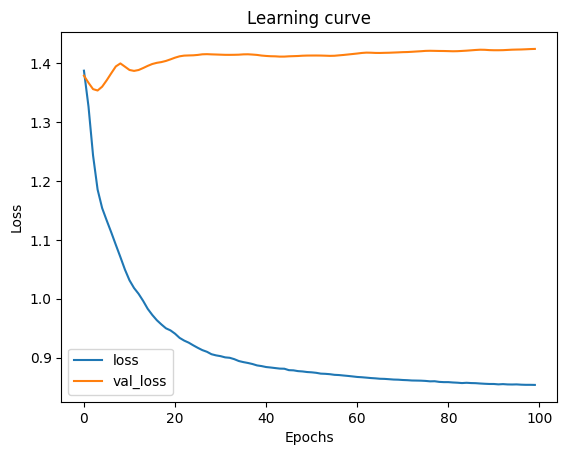

In [3]:
import matplotlib.pyplot as plt
plt.title("Learning curve")
plt.plot(history["train_loss"], label="loss")
plt.plot(history["dev_loss"], label="val_loss")
# plt.plot( np.argmin(history["v_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

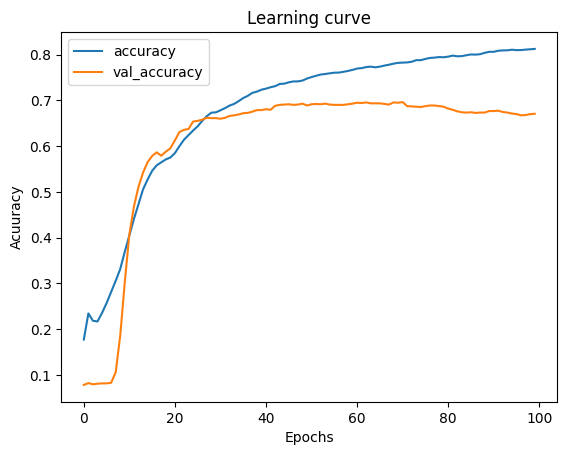

In [4]:
plt.title("Learning curve")
plt.plot(history["train_acc"], label="accuracy")
plt.plot(history["dev_acc"], label="val_accuracy")
# plt.plot( np.argmin(history["v_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Acuuracy")
plt.legend();

In [5]:
from sklearn.metrics import classification_report
y_pred_dev, y_pred_probs, y_true_dev = stanceDetector.get_predictions(x_test, y_test)
#Printing the classifictaion report for the Development set
print(classification_report(y_true_dev, y_pred_dev ,digits =4, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

     support     0.1071    0.0382    0.0563       157
        deny     0.2523    0.2673    0.2596       101
       query     0.1557    0.2043    0.1767        93
     comment     0.8424    0.8801    0.8608      1476

    accuracy                         0.7395      1827
   macro avg     0.3394    0.3475    0.3384      1827
weighted avg     0.7117    0.7395    0.7236      1827



Saving the model

In [6]:
#Saving the model
model_save_name = 'trainedTfidf.pt'
path = F"/content/{model_save_name}" 
torch.save(model.state_dict(), path)

#### Loading the saved model, you can use any pretraied model <br>
**You can go directly to this phase in case you have a pretrained model**

In [2]:
from StanceDetectorModel import StanceDetector,tfidf,Tfidf_Nn
import torch
model = Tfidf_Nn()
model.load_state_dict(torch.load('trainedTfidf.pt'))
model.eval()

Tfidf_Nn(
  (hidden): Linear(in_features=5343, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [3]:
stanceDetector = StanceDetector(model,tfidf) # the class takes in as arguments : the model, and the vectorizer

The example txt file used is as in the image :
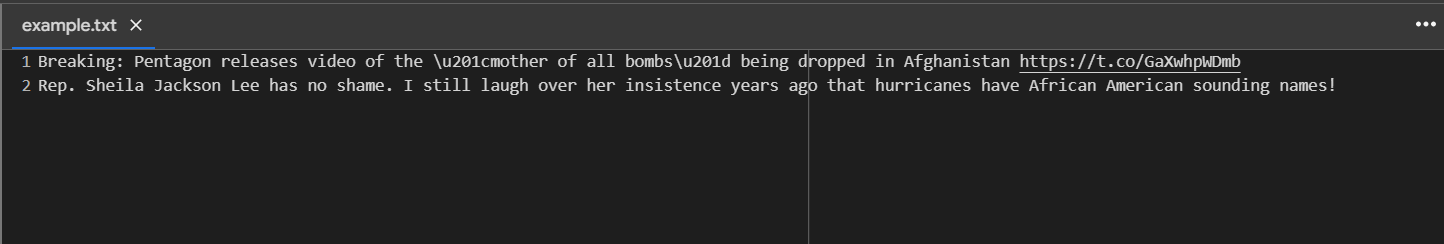

In [4]:
predictions,label_predictions = stanceDetector.predict_new(model,'example.txt')
predictions,label_predictions

(tensor([0, 3]), ['support', 'comment'])